In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_json('telecom_tower_usaged.json')
df = pd.json_normalize(df.to_dict(orient='records'),sep='_')

In [3]:
df.isnull().sum()

timestamp                             0
tower_id                              0
latency_sec                           0
bandwidth                             0
dropped_calls                         0
total_calls                           0
uptime_percent                        0
network_type                          0
operator                              0
users_connected                       0
download_speed_mbps                   0
signal_strength_dbm                   0
tower_load_percent                    0
average_call_duration_sec             0
handover_success_rate                 0
packet_loss_percent                   0
jitter_ms                             0
tower_temperature_c                   0
battery_backup_hours                  0
tower_age_years                       0
maintenance_due                       0
upload_speed_mbps                     0
call_drop_reason                    455
weather_condition                     0
technician_notes                      0


In [4]:
print(df["network_type"].unique())
print(df["network_type"].value_counts())

['5G' 'LTE' '4G']
network_type
5G     3029
LTE    3012
4G     2959
Name: count, dtype: int64


In [5]:
df['network_type'] = df['network_type'].str.upper().str.strip()

In [6]:
valid_types = ["4G", "LTE", "5G"]

# Replace invalid entries with NaN
df.loc[~df["network_type"].isin(valid_types), "network_type"] = None

# Option 1: Drop rows with NaN
df = df.dropna(subset=["network_type"])

# Option 2: Replace with most common type
df["network_type"].fillna(df["network_type"].mode()[0], inplace=True)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18428\1464674230.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["network_type"].fillna(df["network_type"].mode()[0], inplace=True)


In [7]:
df.columns

Index(['timestamp', 'tower_id', 'latency_sec', 'bandwidth', 'dropped_calls',
       'total_calls', 'uptime_percent', 'network_type', 'operator',
       'users_connected', 'download_speed_mbps', 'signal_strength_dbm',
       'tower_load_percent', 'average_call_duration_sec',
       'handover_success_rate', 'packet_loss_percent', 'jitter_ms',
       'tower_temperature_c', 'battery_backup_hours', 'tower_age_years',
       'maintenance_due', 'upload_speed_mbps', 'call_drop_reason',
       'weather_condition', 'technician_notes', 'last_maintenance',
       'tower_color', 'is_test_tower', 'tower_height_m', 'signal_icon',
       'internal_code', 'notes', 'extra_flag', 'location_latitude',
       'location_longitude', 'signal_strength_RSSI', 'signal_strength_RSRP',
       'signal_strength_SINR', 'voip_metrics_jitter_ms',
       'voip_metrics_packet_loss_percent'],
      dtype='object')

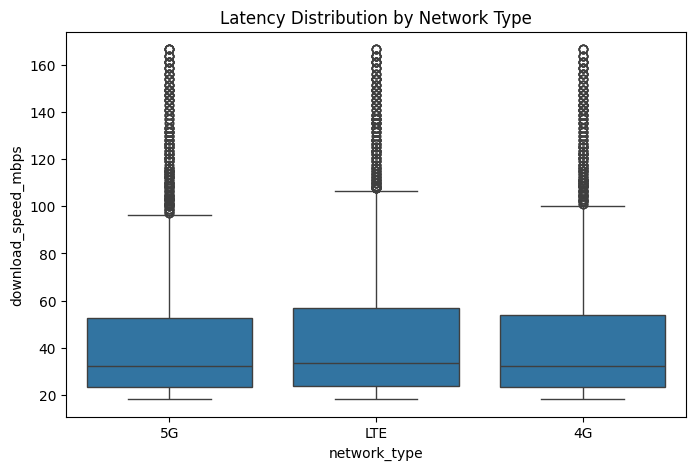

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="network_type", y="download_speed_mbps")
plt.title("Latency Distribution by Network Type")
plt.show()


In [9]:
import numpy as np

# Compute z-score grouped by network type
df["speed_zscore"] = df.groupby("network_type")["download_speed_mbps"].transform(
    lambda x: (x - x.mean()) / x.std()
)

# Flag outliers (e.g., beyond ±3 standard deviations)
outliers = df[df["speed_zscore"].abs() > 3]

print(outliers[["tower_id", "network_type", "download_speed_mbps", "speed_zscore"]])


     tower_id network_type  download_speed_mbps  speed_zscore
129   TWR1097           5G               161.29      3.714197
140   TWR1097           5G               149.25      3.330971
149   TWR1064           5G               166.67      3.885439
165   TWR1015           5G               142.86      3.127581
177   TWR1016           4G               151.52      3.374286
...       ...          ...                  ...           ...
8912  TWR1005          LTE               158.73      3.463057
8915  TWR1052           4G               158.73      3.602709
8949  TWR1063           5G               138.89      3.001219
8968  TWR1050           5G               163.93      3.798227
8984  TWR1009           4G               149.25      3.302370

[229 rows x 4 columns]


In [10]:
def find_outliers_iqr(group):
    Q1 = group.quantile(0.25)
    Q3 = group.quantile(0.75)
    IQR = Q3 - Q1
    return ~group.between(Q1 - 1.5*IQR, Q3 + 1.5*IQR)

# Flag outliers
df["speed_outlier"] = df.groupby("network_type")["download_speed_mbps"].transform(find_outliers_iqr)

# Extract outliers
outliers = df[df["speed_outlier"] == True]
print(outliers[["tower_id", "network_type", "download_speed_mbps"]])


     tower_id network_type  download_speed_mbps
38    TWR1091          LTE               113.64
55    TWR1033           4G               136.99
106   TWR1097           5G               125.00
126   TWR1038           4G               125.00
127   TWR1055           4G               138.89
...       ...          ...                  ...
8958  TWR1074           5G               101.01
8968  TWR1050           5G               163.93
8969  TWR1046          LTE               111.11
8984  TWR1009           4G               149.25
8995  TWR1055           4G               102.04

[716 rows x 3 columns]


In [11]:
def speed_outlier_check(row):
    if row["network_type"] == "4G" and not (10 <= row["download_speed_mbps"] <= 200):
        return True
    if row["network_type"] == "LTE" and not (5 <= row["download_speed_mbps"] <= 100):
        return True
    if row["network_type"] == "5G" and not (20 <= row["download_speed_mbps"] <= 1500):
        return True
    return False

df["speed_outlier_rule"] = df.apply(speed_outlier_check, axis=1)
print(df[df["speed_outlier_rule"] == True][["tower_id", "network_type", "download_speed_mbps"]])


     tower_id network_type  download_speed_mbps
38    TWR1091          LTE               113.64
61    TWR1006           5G                19.01
138   TWR1077           5G                19.53
148   TWR1083           5G                18.42
157   TWR1034           5G                19.34
...       ...          ...                  ...
8906  TWR1096           5G                18.83
8912  TWR1005          LTE               158.73
8934  TWR1078           5G                18.52
8969  TWR1046          LTE               111.11
8974  TWR1052           5G                18.59

[587 rows x 3 columns]


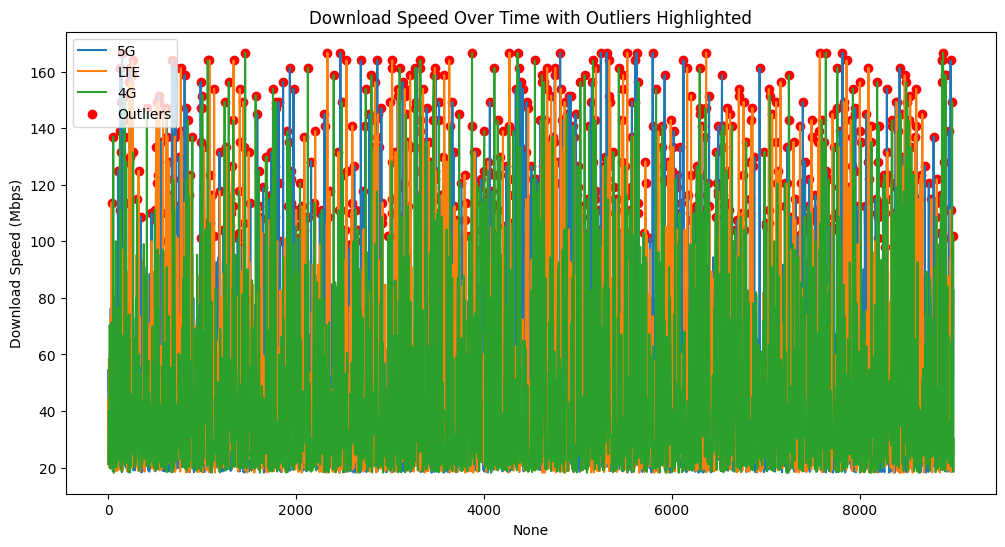

In [12]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x=df.index, y="download_speed_mbps", hue="network_type")
plt.scatter(outliers.index, outliers["download_speed_mbps"], color="red", label="Outliers")
plt.title("Download Speed Over Time with Outliers Highlighted")
plt.ylabel("Download Speed (Mbps)")
plt.legend()
plt.show()


In [13]:
# Remove outliers using IQR method (per network type)
def remove_outliers_iqr(group):
    Q1 = group.quantile(0.25)
    Q3 = group.quantile(0.75)
    IQR = Q3 - Q1
    return group.between(Q1 - 1.5*IQR, Q3 + 1.5*IQR)

df_clean = df.groupby("network_type", group_keys=False).apply(
    lambda g: g[remove_outliers_iqr(g["download_speed_mbps"])]
)

print("Original:", len(df), "Cleaned:", len(df_clean))


Original: 9000 Cleaned: 8284


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18428\804939607.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_clean = df.groupby("network_type", group_keys=False).apply(


In [14]:
def cap_outliers_iqr(group):
    Q1 = group.quantile(0.25)
    Q3 = group.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    return group.clip(lower, upper)

df["download_speed_capped"] = df.groupby("network_type")["download_speed_mbps"].transform(cap_outliers_iqr)


In [15]:
def replace_with_median(group):
    Q1 = group.quantile(0.25)
    Q3 = group.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    median = group.median()
    return group.apply(lambda x: median if x < lower or x > upper else x)

df["download_speed_filled"] = df.groupby("network_type")["download_speed_mbps"].transform(replace_with_median)


In [16]:
def fix_speeds(row):
    if row["network_type"] == "4G":
        return min(max(row["download_speed_mbps"], 10), 200)
    elif row["network_type"] == "LTE":
        return min(max(row["download_speed_mbps"], 5), 100)
    elif row["network_type"] == "5G":
        return min(max(row["download_speed_mbps"], 20), 1500)
    return row["download_speed_mbps"]

df["download_speed_fixed"] = df.apply(fix_speeds, axis=1)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18428\2498012900.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="network_type", y="download_speed_mbps", palette="Set1")


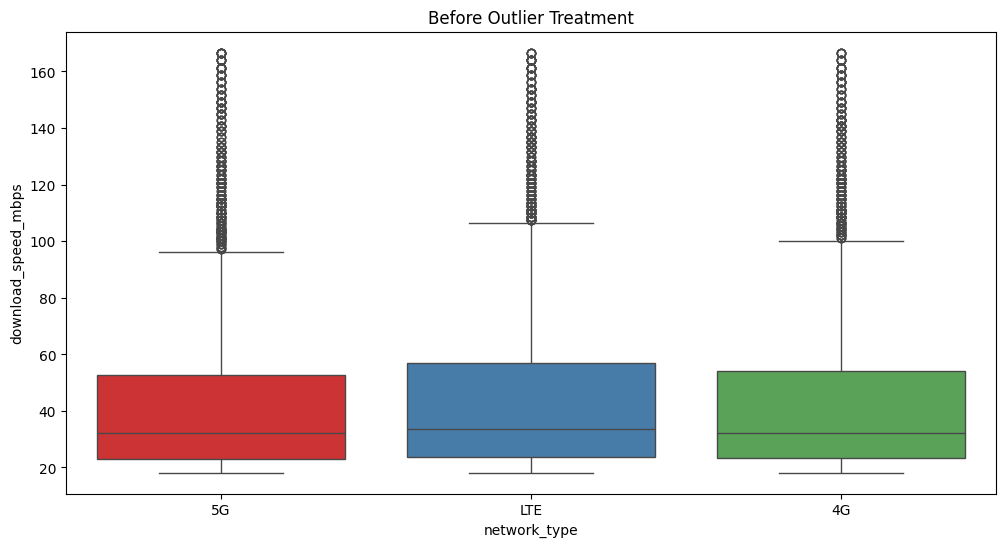

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18428\2498012900.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="network_type", y="download_speed_capped", palette="Set2")


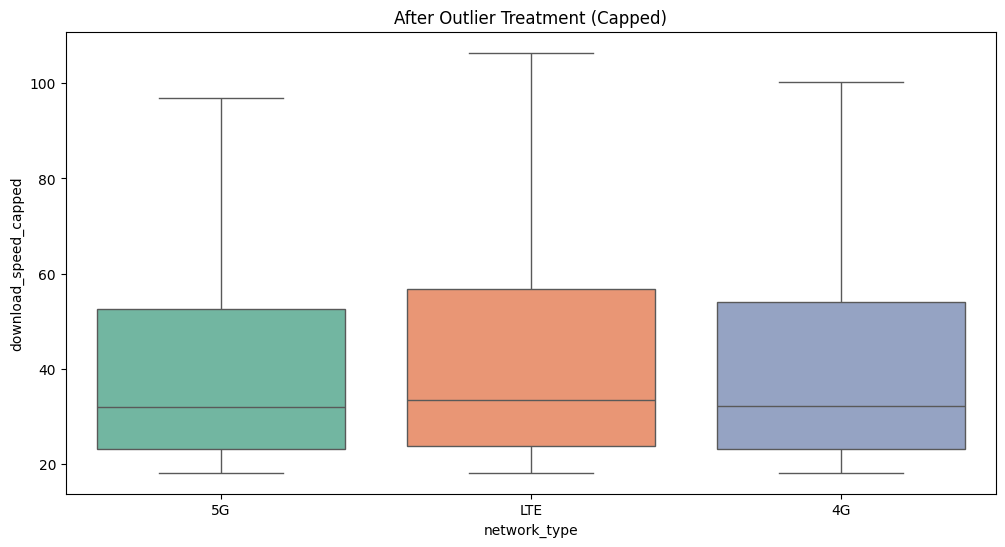

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.boxplot(data=df, x="network_type", y="download_speed_mbps", palette="Set1")
plt.title("Before Outlier Treatment")
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(data=df, x="network_type", y="download_speed_capped", palette="Set2")
plt.title("After Outlier Treatment (Capped)")
plt.show()


In [18]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load and flatten JSON
df = pd.read_json("telecom_tower_usaged.json")
df = pd.json_normalize(df.to_dict(orient="records"), sep="_")

# Select features
features = ["latency_sec", "download_speed_mbps", "tower_load_percent", 
            "dropped_calls", "packet_loss_percent"]

X = df[features].fillna(0)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


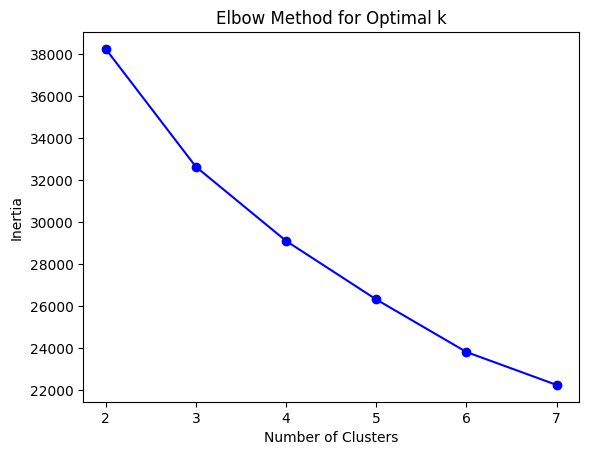

In [19]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Choose number of clusters (elbow method)
inertia = []
K = range(2, 8)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(K, inertia, "bo-")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()


In [20]:
# Fit final model
kmeans = KMeans(n_clusters=4, random_state=42)
df["cluster"] = kmeans.fit_predict(X_scaled)

print(df.groupby("cluster")[features].mean())


         latency_sec  download_speed_mbps  tower_load_percent  dropped_calls  \
cluster                                                                        
0           0.427925            35.187794           81.249544       5.146832   
1           0.357456            34.175523           32.827181       4.816578   
2           0.547801           113.278871           55.723203       5.223237   
3           0.821996            35.081065           49.907596       4.894224   

         packet_loss_percent  
cluster                       
0                   2.471634  
1                   2.538535  
2                   2.495502  
3                   2.495899  


In [21]:
from sklearn.ensemble import IsolationForest

# Train anomaly detector
iso = IsolationForest(contamination=0.05, random_state=42)
df["anomaly"] = iso.fit_predict(X_scaled)

# anomaly = -1 means outlier
anomalies = df[df["anomaly"] == -1]
print(anomalies[["tower_id", "operator", "network_type"] + features])


     tower_id     operator network_type  latency_sec  download_speed_mbps  \
84    TWR1096           O2           4G        0.116               100.00   
129   TWR1097        Three           5G        0.596               161.29   
140   TWR1097           EE           5G        0.468               149.25   
143   TWR1080           EE           5G        0.869               131.58   
149   TWR1064        Three           5G        0.418               166.67   
...       ...          ...          ...          ...                  ...   
8915  TWR1052  Vodafone UK           4G        0.883               158.73   
8939  TWR1070           O2          LTE        0.182                87.72   
8949  TWR1063        Three           5G        0.805               138.89   
8968  TWR1050           O2           5G        0.506               163.93   
8984  TWR1009  Vodafone UK           4G        0.385               149.25   

      tower_load_percent  dropped_calls  packet_loss_percent  
84          

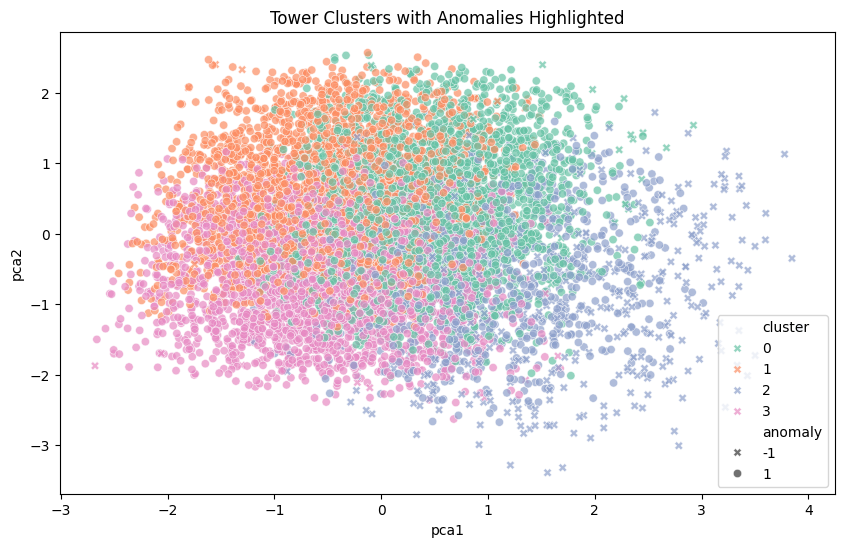

In [22]:
from sklearn.decomposition import PCA
import seaborn as sns

# Reduce to 2D for plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df["pca1"] = X_pca[:,0]
df["pca2"] = X_pca[:,1]

plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x="pca1", y="pca2", hue="cluster", style="anomaly",
                palette="Set2", markers={1:"o", -1:"X"}, alpha=0.7)
plt.title("Tower Clusters with Anomalies Highlighted")
plt.show()


In [23]:
def generate_recommendation(row):
    recs = []

    # Load issues
    if row["tower_load_percent"] > 85 and row["download_speed_mbps"] < 20:
        recs.append("⚠️ Tower overloaded → Add capacity / load balancing")

    # Latency issues
    if row["latency_sec"] > 0.7:
        recs.append("⚡ High latency → Check backhaul/core network")

    # Voice quality issues
    if row["packet_loss_percent"] > 2:
        recs.append("📞 Packet loss high → Optimize VoIP routing/codecs")
    if "voip_metrics_jitter_ms" in row and row["voip_metrics_jitter_ms"] > 30:
        recs.append("📞 High jitter → Review routing paths / bandwidth")

    # Maintenance
    if row.get("maintenance_due", False) and row.get("tower_age_years", 0) > 10:
        recs.append("🛠️ Old tower + maintenance due → Replace/upgrade tower")

    # Anomaly flagged
    if row["anomaly"] == -1:
        recs.append("🚨 Anomaly detected → Send field engineer for inspection")

    return "; ".join(recs) if recs else "✅ Tower healthy"

# Apply recommendations
df["recommendation"] = df.apply(generate_recommendation, axis=1)

# Show sample output
print(df[["tower_id", "operator", "network_type", "recommendation"]].head(10))


  tower_id     operator network_type  \
0  TWR1067           EE           5G   
1  TWR1039        Three          LTE   
2  TWR1086           EE           4G   
3  TWR1060  Vodafone UK           5G   
4  TWR1077           O2          LTE   
5  TWR1066           EE           5G   
6  TWR1025        Three          LTE   
7  TWR1091        Three           4G   
8  TWR1010           O2          LTE   
9  TWR1038  Vodafone UK          LTE   

                                      recommendation  
0  ⚡ High latency → Check backhaul/core network; ...  
1  ⚡ High latency → Check backhaul/core network; ...  
2  📞 Packet loss high → Optimize VoIP routing/codecs  
3  ⚡ High latency → Check backhaul/core network; ...  
4       ⚡ High latency → Check backhaul/core network  
5  📞 Packet loss high → Optimize VoIP routing/codecs  
6                                    ✅ Tower healthy  
7  ⚡ High latency → Check backhaul/core network; ...  
8  📞 Packet loss high → Optimize VoIP routing/cod...  
9  📞 Pack

C:\Users\Lenovo\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128222 (\N{TELEPHONE RECEIVER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Lenovo\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Lenovo\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128736 (\N{HAMMER AND WRENCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Lenovo\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


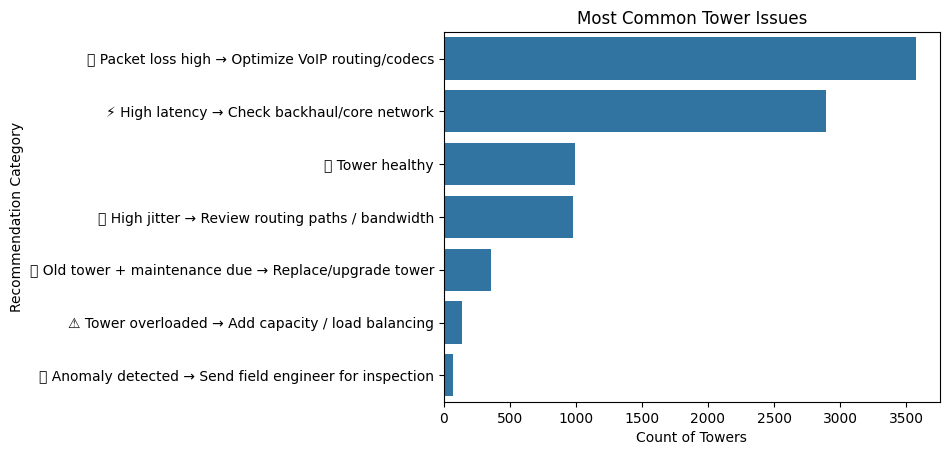

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count most frequent recommendation keywords
df["recommendation_category"] = df["recommendation"].apply(lambda x: x.split(";")[0])  # first issue
sns.countplot(data=df, y="recommendation_category", order=df["recommendation_category"].value_counts().index)

plt.title("Most Common Tower Issues")
plt.xlabel("Count of Towers")
plt.ylabel("Recommendation Category")
plt.show()
